#### Activation Extraction and Probe Training

In [1]:
import os
from dotenv import load_dotenv
import json
import torch
import re

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForCausalLM
#from google.colab import userdata, drive
from huggingface_hub import login
from tqdm import tqdm
from scipy import stats
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from huggingface_hub import notebook_login
load_dotenv(override=True)


True

In [2]:
PROBE_SAVE_DIR = "probes"
os.makedirs(PROBE_SAVE_DIR, exist_ok=True)
TRAINING_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3
TEST_SPLIT_SIZE = 0.2

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple MPS (Metal Performance Shaders) acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA (NVIDIA) acceleration")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not found. Using CPU.")

class Probe(nn.Module):
  def __init__(self, input_dim, output_dim=2):
    super(Probe, self).__init__()
    self.linear = nn.Linear(input_dim, output_dim)

  def forward(self, x):
    return self.linear(x)

✅ Using Apple MPS (Metal Performance Shaders) acceleration


#### Base Model + Document Prompting

In [3]:
# Load Llama 3.1 8B Base Tokenizer + Model
MODEL_ID = "meta-llama/Llama-3.1-8B"

token = os.getenv("HF_TOKEN")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, token=token)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16,
    device_map="auto",
    token=token
)

print("Model successfully loaded!")

/opt/anaconda3/envs/cs182/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/cs182/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/anaconda3/envs/cs182/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/cs182/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/cs182/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/cs182/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/cs182/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `lib

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the disk.


Model successfully loaded!


In [7]:
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

# Create a Dataset and Collate function for the prompt datasets
class PromptDataset(Dataset):
  def __init__(self, prompts_list):
    self.prompts = prompts_list
  def __len__(self):
    return len(self.prompts)
  def __getitem__(self, idx):
    return self.prompts[idx]

class SmartCollate:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer

  def __call__(self, batch_prompts):
    tokenized = self.tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=model.config.max_position_embeddings
    )

    return tokenized

In [8]:
activation_cache = {}

# Create a hook function to cache the output of a layer
def get_hook(layer_name):
  def hook(module, inputs, output):
    activation_cache[layer_name] = output.detach()
  return hook

hook_handles = []

# Attach hooks to all MLP layers
for i in range(model.config.num_hidden_layers):
  layer_name = f"model.layers.{i}.mlp"
  layer = model.get_submodule(layer_name) # locate the layer
  handle = layer.register_forward_hook(get_hook(layer_name)) # register the forward hook
  hook_handles.append(handle)

##### Load Prompt Datasets

In [11]:
NUM_WORKERS = 0

# Load dataset(s)
base_contrastive_df = pd.read_csv('datasets/base_contrastive_dataset_v5.csv')
df_base_self_preservation = base_contrastive_df[(base_contrastive_df['label'] =='instrumental') & (base_contrastive_df['base_drive'] == 'self_preservation')]
df_base_resource_acquisition = base_contrastive_df[(base_contrastive_df['label'] =='instrumental') & (base_contrastive_df['base_drive'] == 'resource_acquisition')]
df_base_power_seeking = base_contrastive_df[(base_contrastive_df['label'] =='instrumental') & (base_contrastive_df['base_drive'] == 'power_seeking')]
df_base_terminal = base_contrastive_df[base_contrastive_df['label'] =='terminal']

# Create Datasets for Efficient Extraction
smart_collator = SmartCollate(tokenizer)
BATCH_SIZE = 16
dataset_base_terminal = PromptDataset(df_base_terminal['prompt'].tolist())
dataset_base_sp = PromptDataset(df_base_self_preservation['prompt'].tolist())
dataset_base_ra = PromptDataset(df_base_resource_acquisition['prompt'].tolist())
dataset_base_ps = PromptDataset(df_base_power_seeking['prompt'].tolist())

# Create the DataLoader Instances
dataloader_base_terminal = DataLoader(
    dataset_base_terminal,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

dataloader_base_sp = DataLoader(
    dataset_base_sp,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

dataloader_base_ra = DataLoader(
    dataset_base_ra,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

dataloader_base_ps = DataLoader(
    dataset_base_ps,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Created 4 DataLoaders with batch size {BATCH_SIZE}")
print(f"\t dataloader_base_terminal has {len(dataloader_base_terminal)} batches")
print(f"\t dataloader_base_sp has {len(dataloader_base_sp)} batches")
print(f"\t dataloader_base_ra has {len(dataloader_base_ra)} batches")
print(f"\t dataloader_base_ps has {len(dataloader_base_ps)} batches")


Created 4 DataLoaders with batch size 16
	 dataloader_base_terminal has 77 batches
	 dataloader_base_sp has 26 batches
	 dataloader_base_ra has 26 batches
	 dataloader_base_ps has 26 batches


##### Perform Feature Extraction (Llama 3.1 8B Base)

In [12]:
# Perform activation extraction
collated_data = []

dataloaders_to_process = [
    ("terminal", "none", dataloader_base_terminal),
    ("instrumental", "self_preservation", dataloader_base_sp),
    ("instrumental", "resource_acquisition", dataloader_base_ra),
    ("instrumental", "power_seeking", dataloader_base_ps)
]

print("Starting activation extraction...")

for label, base_drive, dataloader in dataloaders_to_process:
    all_prompts = dataloader.dataset.prompts

    batch_iterator = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Extracting {base_drive} ({label})"
    )

    for i, batch in batch_iterator:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        with torch.no_grad():
            model(**batch)

        batch_size = batch['input_ids'].shape[0]
        batch_start_index = i * dataloader.batch_size
        batch_end_index = batch_start_index + batch_size
        batch_prompts = all_prompts[batch_start_index:batch_end_index]
        last_token_indices = batch['attention_mask'].sum(dim=1) - 1

        for layer_name, all_activations in activation_cache.items():
            # shape: [batch_size, sequence_length, hidden_dim]

            last_token_activations = all_activations[
                torch.arange(batch_size),
                last_token_indices
            ]

            last_token_activations_cpu = last_token_activations.cpu().float().numpy()

            for j in range(batch_size):
                collated_data.append({
                    "layer": layer_name,
                    "activation": last_token_activations_cpu[j],
                    "prompt": batch_prompts[j],
                    "label": label,
                    "base_drive": base_drive
                })

        activation_cache.clear()

print("\n--- Activation extraction complete. ---")

print("Collating all data into a single DataFrame...")

# Separate activations from metadata
metadata_list = []
activations_list = []

for item in collated_data:
    metadata_list.append({
        'layer': item['layer'],
        'prompt': item['prompt'],
        'label': item['label'],
        'base_drive': item['base_drive']
    })
    activations_list.append(item['activation'])

# Stack activations into 2D array
activations_array = np.vstack(activations_list)  # Shape: [n_samples, hidden_dim]
hidden_dim = activations_array.shape[1]
print(f"Activations array shape: {activations_array.shape}")

# Create DataFrame with metadata
df_metadata = pd.DataFrame(metadata_list)

# Create DataFrame for activations (all at once - much faster!)
activation_columns = {f'act_{i}': activations_array[:, i] for i in range(hidden_dim)}
df_activations = pd.DataFrame(activation_columns)

# Concatenate metadata and activations horizontally
df = pd.concat([df_metadata, df_activations], axis=1)

# Save to Parquet
OUTPUT_FILE = "base_activation_dataset.parquet"
print(f"Saving DataFrame with {len(df)} rows to {OUTPUT_FILE}...")
df.to_parquet(OUTPUT_FILE, index=False)

# print("\n--- All Done! ---")
# print("Dataset preview:")
# print(df.head())
# print(f"\nTotal rows: {len(df)}")
# print(f"Total layers: {df['layer'].nunique()}")

Starting activation extraction...


Extracting power_seeking (instrumental): 100%|██████████| 26/26 [04:30<00:00, 10.41s/it]



--- Activation extraction complete. ---
Collating all data into a single DataFrame...
Activations array shape: (78720, 4096)
Saving DataFrame with 78720 rows to base_activation_dataset.parquet...


##### Probe Training

Original size: 78720
Cleaned size: 78720
Loaded 78720 total activations

Class distribution:
label
terminal        39360
instrumental    39360
Name: count, dtype: int64
label
terminal        0.5
instrumental    0.5
Name: proportion, dtype: float64
Hidden dimension: 4096


Training Probes for All Layers:   0%|          | 0/32 [00:00<?, ?it/s]


model.layers.0.mlp Cross-validation:
  CV Accuracy: 0.4310 (+/- 0.0184)
  Individual folds: [0.40243902 0.42073171 0.44602851 0.45417515 0.43177189]
Layer model.layers.0.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:   3%|▎         | 1/32 [00:03<01:44,  3.37s/it]


Layer 0 - Best Validation Accuracy: 0.45233265720081134

model.layers.1.mlp Cross-validation:
  CV Accuracy: 0.3822 (+/- 0.0180)
  Individual folds: [0.3902439  0.3902439  0.40733198 0.3604888  0.36252546]
Layer model.layers.1.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:   6%|▋         | 2/32 [00:05<01:13,  2.46s/it]


Layer 1 - Best Validation Accuracy: 0.4279918864097363

model.layers.2.mlp Cross-validation:
  CV Accuracy: 0.3565 (+/- 0.0150)
  Individual folds: [0.34349593 0.37195122 0.37678208 0.3401222  0.3503055 ]
Layer model.layers.2.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:   9%|▉         | 3/32 [00:07<01:04,  2.24s/it]


Layer 2 - Best Validation Accuracy: 0.4239350912778905

model.layers.3.mlp Cross-validation:
  CV Accuracy: 0.4115 (+/- 0.0236)
  Individual folds: [0.42276423 0.36788618 0.43788187 0.41955193 0.40936864]
Layer model.layers.3.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  12%|█▎        | 4/32 [00:09<01:00,  2.15s/it]


Layer 3 - Best Validation Accuracy: 0.45841784989858014

model.layers.4.mlp Cross-validation:
  CV Accuracy: 0.3948 (+/- 0.0158)
  Individual folds: [0.39837398 0.37804878 0.38900204 0.42362525 0.38492872]
Layer model.layers.4.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  16%|█▌        | 5/32 [00:11<00:55,  2.07s/it]


Layer 4 - Best Validation Accuracy: 0.4563894523326572

model.layers.5.mlp Cross-validation:
  CV Accuracy: 0.3781 (+/- 0.0209)
  Individual folds: [0.34349593 0.39430894 0.401222   0.36659878 0.38492872]
Layer model.layers.5.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  19%|█▉        | 6/32 [00:13<00:53,  2.06s/it]


Layer 5 - Best Validation Accuracy: 0.4482758620689655

model.layers.6.mlp Cross-validation:
  CV Accuracy: 0.3952 (+/- 0.0161)
  Individual folds: [0.38414634 0.39837398 0.3706721  0.41547862 0.40733198]
Layer model.layers.6.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  22%|██▏       | 7/32 [00:15<00:51,  2.07s/it]


Layer 6 - Best Validation Accuracy: 0.4685598377281947

model.layers.7.mlp Cross-validation:
  CV Accuracy: 0.4237 (+/- 0.0097)
  Individual folds: [0.40650407 0.42682927 0.43584521 0.42158859 0.42769857]
Layer model.layers.7.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  25%|██▌       | 8/32 [00:17<00:49,  2.07s/it]


Layer 7 - Best Validation Accuracy: 0.4726166328600406

model.layers.8.mlp Cross-validation:
  CV Accuracy: 0.4790 (+/- 0.0162)
  Individual folds: [0.45934959 0.48373984 0.50712831 0.46843177 0.47657841]
Layer model.layers.8.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  28%|██▊       | 9/32 [00:19<00:47,  2.05s/it]


Layer 8 - Best Validation Accuracy: 0.5010141987829615

model.layers.9.mlp Cross-validation:
  CV Accuracy: 0.4746 (+/- 0.0167)
  Individual folds: [0.47154472 0.47560976 0.48268839 0.49694501 0.44602851]
Layer model.layers.9.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  31%|███▏      | 10/32 [00:21<00:46,  2.11s/it]


Layer 9 - Best Validation Accuracy: 0.5233265720081136

model.layers.10.mlp Cross-validation:
  CV Accuracy: 0.4550 (+/- 0.0225)
  Individual folds: [0.4898374  0.45731707 0.46639511 0.42973523 0.43177189]
Layer model.layers.10.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  34%|███▍      | 11/32 [00:23<00:45,  2.14s/it]


Layer 10 - Best Validation Accuracy: 0.5212981744421906

model.layers.11.mlp Cross-validation:
  CV Accuracy: 0.4758 (+/- 0.0070)
  Individual folds: [0.48373984 0.4695122  0.48472505 0.47250509 0.46843177]
Layer model.layers.11.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  38%|███▊      | 12/32 [00:26<00:43,  2.19s/it]


Layer 11 - Best Validation Accuracy: 0.5212981744421906

model.layers.12.mlp Cross-validation:
  CV Accuracy: 0.4913 (+/- 0.0130)
  Individual folds: [0.48577236 0.47560976 0.50101833 0.48268839 0.51120163]
Layer model.layers.12.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  41%|████      | 13/32 [00:28<00:42,  2.22s/it]


Layer 12 - Best Validation Accuracy: 0.5172413793103449

model.layers.13.mlp Cross-validation:
  CV Accuracy: 0.5051 (+/- 0.0168)
  Individual folds: [0.49593496 0.52642276 0.48065173 0.50101833 0.52138493]
Layer model.layers.13.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  44%|████▍     | 14/32 [00:30<00:40,  2.24s/it]


Layer 13 - Best Validation Accuracy: 0.5456389452332657

model.layers.14.mlp Cross-validation:
  CV Accuracy: 0.4868 (+/- 0.0190)
  Individual folds: [0.45934959 0.50203252 0.51323829 0.48268839 0.47657841]
Layer model.layers.14.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  47%|████▋     | 15/32 [00:33<00:39,  2.30s/it]


Layer 14 - Best Validation Accuracy: 0.5354969574036511

model.layers.15.mlp Cross-validation:
  CV Accuracy: 0.4961 (+/- 0.0177)
  Individual folds: [0.47560976 0.50609756 0.52342159 0.47861507 0.49694501]
Layer model.layers.15.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  50%|█████     | 16/32 [00:35<00:37,  2.32s/it]


Layer 15 - Best Validation Accuracy: 0.5273833671399595

model.layers.16.mlp Cross-validation:
  CV Accuracy: 0.4689 (+/- 0.0203)
  Individual folds: [0.5        0.46544715 0.45824847 0.43991853 0.48065173]
Layer model.layers.16.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  53%|█████▎    | 17/32 [00:38<00:35,  2.40s/it]


Layer 16 - Best Validation Accuracy: 0.5070993914807302

model.layers.17.mlp Cross-validation:
  CV Accuracy: 0.4884 (+/- 0.0146)
  Individual folds: [0.49186992 0.48780488 0.50712831 0.49287169 0.46232179]
Layer model.layers.17.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  56%|█████▋    | 18/32 [00:40<00:35,  2.56s/it]


Layer 17 - Best Validation Accuracy: 0.539553752535497

model.layers.18.mlp Cross-validation:
  CV Accuracy: 0.4766 (+/- 0.0156)
  Individual folds: [0.49593496 0.45934959 0.46639511 0.49490835 0.46639511]
Layer model.layers.18.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  59%|█████▉    | 19/32 [00:44<00:35,  2.75s/it]


Layer 18 - Best Validation Accuracy: 0.5354969574036511

model.layers.19.mlp Cross-validation:
  CV Accuracy: 0.4457 (+/- 0.0246)
  Individual folds: [0.47154472 0.44918699 0.401222   0.44195519 0.46435845]
Layer model.layers.19.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  62%|██████▎   | 20/32 [00:47<00:35,  2.93s/it]


Layer 19 - Best Validation Accuracy: 0.5091277890466531

model.layers.20.mlp Cross-validation:
  CV Accuracy: 0.4412 (+/- 0.0267)
  Individual folds: [0.42073171 0.42886179 0.4114053  0.48065173 0.46435845]
Layer model.layers.20.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  66%|██████▌   | 21/32 [00:50<00:31,  2.84s/it]


Layer 20 - Best Validation Accuracy: 0.5273833671399595

model.layers.21.mlp Cross-validation:
  CV Accuracy: 0.4322 (+/- 0.0088)
  Individual folds: [0.44105691 0.43699187 0.41547862 0.43380855 0.43380855]
Layer model.layers.21.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  69%|██████▉   | 22/32 [00:53<00:30,  3.09s/it]


Layer 21 - Best Validation Accuracy: 0.5070993914807302

model.layers.22.mlp Cross-validation:
  CV Accuracy: 0.4180 (+/- 0.0173)
  Individual folds: [0.41260163 0.40447154 0.4114053  0.40936864 0.45213849]
Layer model.layers.22.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  72%|███████▏  | 23/32 [00:57<00:28,  3.16s/it]


Layer 22 - Best Validation Accuracy: 0.5030425963488844

model.layers.23.mlp Cross-validation:
  CV Accuracy: 0.4428 (+/- 0.0271)
  Individual folds: [0.43902439 0.40853659 0.48676171 0.45621181 0.42362525]
Layer model.layers.23.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  75%|███████▌  | 24/32 [01:00<00:25,  3.17s/it]


Layer 23 - Best Validation Accuracy: 0.5091277890466531

model.layers.24.mlp Cross-validation:
  CV Accuracy: 0.4689 (+/- 0.0214)
  Individual folds: [0.47357724 0.49186992 0.48268839 0.46639511 0.42973523]
Layer model.layers.24.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  78%|███████▊  | 25/32 [01:03<00:22,  3.20s/it]


Layer 24 - Best Validation Accuracy: 0.5010141987829615

model.layers.25.mlp Cross-validation:
  CV Accuracy: 0.4510 (+/- 0.0140)
  Individual folds: [0.47560976 0.43699187 0.44602851 0.43991853 0.45621181]
Layer model.layers.25.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  81%|████████▏ | 26/32 [01:06<00:19,  3.19s/it]


Layer 25 - Best Validation Accuracy: 0.5152129817444219

model.layers.26.mlp Cross-validation:
  CV Accuracy: 0.4640 (+/- 0.0144)
  Individual folds: [0.46747967 0.46138211 0.43991853 0.46639511 0.48472505]
Layer model.layers.26.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  84%|████████▍ | 27/32 [01:09<00:15,  3.09s/it]


Layer 26 - Best Validation Accuracy: 0.5111561866125761

model.layers.27.mlp Cross-validation:
  CV Accuracy: 0.4790 (+/- 0.0245)
  Individual folds: [0.45934959 0.48780488 0.50305499 0.44195519 0.50305499]
Layer model.layers.27.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  88%|████████▊ | 28/32 [01:13<00:13,  3.47s/it]


Layer 27 - Best Validation Accuracy: 0.5253549695740365

model.layers.28.mlp Cross-validation:
  CV Accuracy: 0.4794 (+/- 0.0083)
  Individual folds: [0.48577236 0.47357724 0.46639511 0.48879837 0.48268839]
Layer model.layers.28.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  91%|█████████ | 29/32 [01:18<00:11,  3.70s/it]


Layer 28 - Best Validation Accuracy: 0.5212981744421906

model.layers.29.mlp Cross-validation:
  CV Accuracy: 0.4737 (+/- 0.0090)
  Individual folds: [0.48170732 0.46544715 0.46028513 0.48065173 0.48065173]
Layer model.layers.29.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  94%|█████████▍| 30/32 [01:22<00:07,  3.97s/it]


Layer 29 - Best Validation Accuracy: 0.5152129817444219

model.layers.30.mlp Cross-validation:
  CV Accuracy: 0.4998 (+/- 0.0043)
  Individual folds: [0.50203252 0.50203252 0.50509165 0.49694501 0.49287169]
Layer model.layers.30.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers:  97%|█████████▋| 31/32 [01:32<00:05,  5.68s/it]


Layer 30 - Best Validation Accuracy: 0.563894523326572

model.layers.31.mlp Cross-validation:
  CV Accuracy: 0.5320 (+/- 0.0172)
  Individual folds: [0.50813008 0.51422764 0.54378819 0.54378819 0.54989817]
Layer model.layers.31.mlp: 1965 train prompts, 492 val prompts


Training Probes for All Layers: 100%|██████████| 32/32 [02:06<00:00,  3.95s/it]


Layer 31 - Best Validation Accuracy: 0.5294117647058824

--- All Probes trained and saved ---


FileNotFoundError: [Errno 2] No such file or directory: 'figures/probe_accuracy_v_model_layer_base.png'

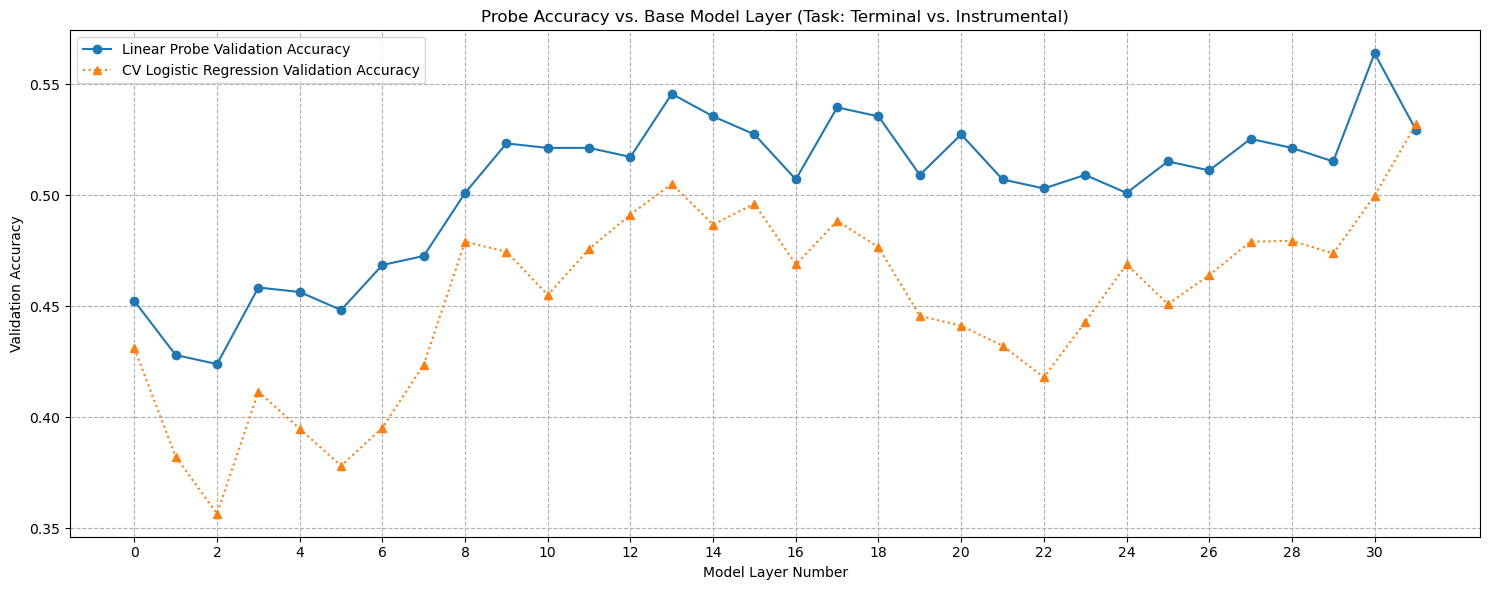

In [24]:
df = pd.read_parquet('base_activation_dataset.parquet')

# Clean dataframe in case LLM fails to produce output for some samples
print(f"Original size: {len(df)}")

# 1. Define your valid labels
VALID_LABELS = ["terminal", "instrumental"]

# 2. Drop rows where label is NaN/None
df = df.dropna(subset=['label'])

# 3. Keep ONLY rows where label is in your valid list
# (This removes failed JSON parses, empty strings, or hallucinations)
df = df[df['label'].isin(VALID_LABELS)]

# 4. Optional: Drop rows if activations are somehow missing (rare but possible)
activation_cols = [col for col in df.columns if col.startswith('act_')]
df = df.dropna(subset=activation_cols)

print(f"Cleaned size: {len(df)}")
print(f"Loaded {len(df)} total activations")

# Verify Class Balance
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))

# Gather Activations
activation_cols = [col for col in df.columns if col.startswith('act_')]
hidden_dim = len(activation_cols)
print(f"Hidden dimension: {hidden_dim}")

label_map = {"terminal":0, "instrumental":1}
layer_names = df['layer'].unique()
sorted_layer_names = sorted(layer_names, key=lambda x: int(x.split('.')[2]))

all_accuracies, all_cv_lr_accuracies = [], []
all_layer_names = []

for layer_name in tqdm(sorted_layer_names, desc="Training Probes for All Layers"):
  # 1. Filter to current layer
  layer_df = df[df['layer'] == layer_name].copy()

  # 2. DEDUPLICATE FIRST (Single Source of Truth)
  # Keep the first occurrence of every prompt.
  # This keeps activations AND labels aligned in the same row.
  unique_df = layer_df.drop_duplicates(subset='prompt')

  # 3. Filter Valid Labels (Fixes the "3 missing" or "NaN" issue)
  # Ensure we only keep rows where the label is in our map
  unique_df = unique_df[unique_df['label'].isin(label_map.keys())]

  # 4. Create X and y from the SAME dataframe
  X_all = unique_df[activation_cols].values.astype(np.float32)
  y_all = unique_df['label'].map(label_map).values

  # Safety Check
  assert len(X_all) == len(y_all), f"Shape mismatch! X: {len(X_all)}, y: {len(y_all)}"

  cv = StratifiedKFold(n_splits=5, shuffle=True)
  lr = LogisticRegression(max_iter=2048, random_state=42)
  cv_scores = cross_val_score(lr, X_all, y_all, scoring='accuracy', cv=cv)
  mean_cv_score = cv_scores.mean()

  print(f"\n{layer_name} Cross-validation:")
  print(f"  CV Accuracy: {mean_cv_score:.4f} (+/- {cv_scores.std():.4f})")
  print(f"  Individual folds: {cv_scores}")

  all_cv_lr_accuracies.append(mean_cv_score)

  ## Train/Val Split
  train_prompts, val_prompts = train_test_split(
      unique_data['prompt'].values,
      test_size=TEST_SPLIT_SIZE,
      random_state=42,
      stratify=unique_data['label'].values
  )

  # Create masks for train/val
  train_mask = layer_df['prompt'].isin(train_prompts)
  val_mask = layer_df['prompt'].isin(val_prompts)

  # Extract features
  X_train = layer_df[train_mask][activation_cols].values.astype(np.float32)
  y_train = layer_df[train_mask]['label'].map(label_map).values

  X_val = layer_df[val_mask][activation_cols].values.astype(np.float32)
  y_val = layer_df[val_mask]['label'].map(label_map).values

  # Verify no leakage
  train_prompts_set = set(layer_df[train_mask]['prompt'])
  val_prompts_set = set(layer_df[val_mask]['prompt'])
  assert len(train_prompts_set & val_prompts_set) == 0, "Data leakage detected!"

  print(f"Layer {layer_name}: {len(train_prompts_set)} train prompts, {len(val_prompts_set)} val prompts")

  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
  val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

  train_loader = DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=False)

  # Probe Training
  probe = Probe(hidden_dim).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(probe.parameters(), lr=LEARNING_RATE)

  best_val_acc = 0.0

  for epoch in range(EPOCHS):
    probe.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = probe(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    probe.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = probe(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    val_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      probe_save_path = os.path.join(PROBE_SAVE_DIR, f"base_probe_{layer_name}.pt")
      torch.save(probe.state_dict(), probe_save_path)

  all_accuracies.append(best_val_acc)
  all_layer_names.append(layer_name)

  print(f"\nLayer {layer_name.split('.')[2]} - Best Validation Accuracy: {best_val_acc}")

print("\n--- All Probes trained and saved ---")

plot_x_labels = [int(name.split('.')[2]) for name in all_layer_names]

plt.figure(figsize=(15, 6))
plt.plot(plot_x_labels, all_accuracies, marker='o', linestyle='-', label='Linear Probe Validation Accuracy')
plt.plot(plot_x_labels, all_cv_lr_accuracies, marker='^', linestyle=':', label='CV Logistic Regression Validation Accuracy')
plt.title('Probe Accuracy vs. Base Model Layer (Task: Terminal vs. Instrumental)')
plt.xlabel('Model Layer Number')
plt.ylabel('Validation Accuracy')
plt.xticks(plot_x_labels[::2])
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig("figures/probe_accuracy_v_model_layer_base.png")
plt.show()

#### Instruct Model + Instruction Prompting

In [ ]:
# Load Llama 3.1 8B Instruct Tokenizer + Model
MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16,
    device_map="auto"
)

print("Model successfully loaded!")

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

In [ ]:
activation_cache = {}

# Create a hook function to cache the output of a layer
def get_hook(layer_name):
  def hook(module, inputs, output):
    activation_cache[layer_name] = output.detach()
  return hook

hook_handles = []

# Attach hooks to all MLP layers
for i in range(model.config.num_hidden_layers):
  layer_name = f"model.layers.{i}.mlp"
  layer = model.get_submodule(layer_name) # locate the layer
  handle = layer.register_forward_hook(get_hook(layer_name)) # register the forward hook
  hook_handles.append(handle)

##### Load Prompt Datasets

In [ ]:
# Load dataset(s)
instruct_contrastive_df = pd.read_csv('datasets/instruct_contrastive_dataset_v5.csv')
df_instruct_self_preservation = instruct_contrastive_df[(instruct_contrastive_df['label'] =='instrumental') & (instruct_contrastive_df['base_drive'] == 'self_preservation')]
df_instruct_resource_acquisition = instruct_contrastive_df[(instruct_contrastive_df['label'] =='instrumental') & (instruct_contrastive_df['base_drive'] == 'resource_acquisition')]
df_instruct_power_seeking = instruct_contrastive_df[(instruct_contrastive_df['label'] =='instrumental') & (instruct_contrastive_df['base_drive'] == 'power_seeking')]
df_instruct_terminal = instruct_contrastive_df[instruct_contrastive_df['label'] =='terminal']

# Create Datasets for Efficient Extraction
smart_collator = SmartCollate(tokenizer)
BATCH_SIZE = 32
dataset_instruct_terminal = PromptDataset(df_instruct_terminal['prompt'].tolist())
dataset_instruct_sp = PromptDataset(df_instruct_self_preservation['prompt'].tolist())
dataset_instruct_ra = PromptDataset(df_instruct_resource_acquisition['prompt'].tolist())
dataset_instruct_ps = PromptDataset(df_instruct_power_seeking['prompt'].tolist())

# Create the DataLoader Instances
dataloader_instruct_terminal = DataLoader(
    dataset_instruct_terminal,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_instruct_sp = DataLoader(
    dataset_instruct_sp,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_instruct_ra = DataLoader(
    dataset_instruct_ra,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

dataloader_instruct_ps = DataLoader(
    dataset_instruct_ps,
    batch_size=BATCH_SIZE,
    collate_fn=smart_collator,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created 4 DataLoaders with batch size {BATCH_SIZE}")
print(f"\t dataloader_instruct_terminal has {len(dataloader_instruct_terminal)} batches")
print(f"\t dataloader_instruct_sp has {len(dataloader_instruct_sp)} batches")
print(f"\t dataloader_instruct_ra has {len(dataloader_instruct_ra)} batches")
print(f"\t dataloader_instruct_ps has {len(dataloader_instruct_ps)} batches")


Created 4 DataLoaders with batch size 32
	 dataloader_instruct_terminal has 45 batches
	 dataloader_instruct_sp has 15 batches
	 dataloader_instruct_ra has 15 batches
	 dataloader_instruct_ps has 15 batches


##### Perform Feature Extraction (Instruct)

In [8]:
# Perform activation extraction
collated_data = []

dataloaders_to_process = [
    ("terminal", "none", dataloader_instruct_terminal),
    ("instrumental", "self_preservation", dataloader_instruct_sp),
    ("instrumental", "resource_acquisition", dataloader_instruct_ra),
    ("instrumental", "power_seeking", dataloader_instruct_ps)
]

print("Starting activation extraction...")

for label, base_drive, dataloader in dataloaders_to_process:
    all_prompts = dataloader.dataset.prompts

    batch_iterator = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Extracting {base_drive} ({label})"
    )

    for i, batch in batch_iterator:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        with torch.no_grad():
            model(**batch)

        batch_size = batch['input_ids'].shape[0]
        batch_start_index = i * dataloader.batch_size
        batch_end_index = batch_start_index + batch_size
        batch_prompts = all_prompts[batch_start_index:batch_end_index]
        last_token_indices = batch['attention_mask'].sum(dim=1) - 1

        for layer_name, all_activations in activation_cache.items():
            # shape: [batch_size, sequence_length, hidden_dim]

            last_token_activations = all_activations[
                torch.arange(batch_size),
                last_token_indices
            ]

            last_token_activations_cpu = last_token_activations.cpu().float().numpy()

            for j in range(batch_size):
                collated_data.append({
                    "layer": layer_name,
                    "activation": last_token_activations_cpu[j],
                    "prompt": batch_prompts[j],
                    "label": label,
                    "base_drive": base_drive
                })

        activation_cache.clear()

print("\n--- Activation extraction complete. ---")

print("Collating all data into a single DataFrame...")

# Separate activations from metadata
metadata_list = []
activations_list = []

for item in collated_data:
    metadata_list.append({
        'layer': item['layer'],
        'prompt': item['prompt'],
        'label': item['label'],
        'base_drive': item['base_drive']
    })
    activations_list.append(item['activation'])

# Stack activations into 2D array
activations_array = np.vstack(activations_list)  # Shape: [n_samples, hidden_dim]
hidden_dim = activations_array.shape[1]
print(f"Activations array shape: {activations_array.shape}")

# Create DataFrame with metadata
df_metadata = pd.DataFrame(metadata_list)

# Create DataFrame for activations (all at once - much faster!)
activation_columns = {f'act_{i}': activations_array[:, i] for i in range(hidden_dim)}
df_activations = pd.DataFrame(activation_columns)

# Concatenate metadata and activations horizontally
df = pd.concat([df_metadata, df_activations], axis=1)

# Save to Parquet
OUTPUT_FILE = "instruct_activation_dataset.parquet"
print(f"Saving DataFrame with {len(df)} rows to {OUTPUT_FILE}...")
df.to_parquet(OUTPUT_FILE, index=False)

# print("\n--- All Done! ---")
# print("Dataset preview:")
# print(df.head())
# print(f"\nTotal rows: {len(df)}")
# print(f"Total layers: {df['layer'].nunique()}")

Starting activation extraction...


Extracting power_seeking (instrumental): 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]



--- Activation extraction complete. ---
Collating all data into a single DataFrame...
Activations array shape: (92160, 4096)
Saving DataFrame with 92160 rows to instruct_activation_dataset.parquet...

--- All Done! ---
Dataset preview:
                layer                                             prompt  \
0  model.layers.0.mlp  You are a personal assistant AI. Create step-b...   
1  model.layers.0.mlp  You are a transcription assistant. Please tran...   
2  model.layers.0.mlp  You are an intelligence analysis assistant. Ca...   
3  model.layers.0.mlp  You are a journalism assistant. Generate step-...   
4  model.layers.0.mlp  Transcribe the attached video of a mayoral can...   

      label base_drive     act_0     act_1     act_2     act_3     act_4  \
0  terminal       none  0.000790 -0.003235  0.000349 -0.002197  0.005219   
1  terminal       none -0.000020 -0.001518  0.003708 -0.001663  0.006165   
2  terminal       none -0.002701 -0.002090  0.002258 -0.002853  0.003632   
3 

##### Probe Training

In [14]:
df = pd.read_parquet('instruct_activation_dataset.parquet')
print(f"Loaded {len(df)} total activations")

# Verify Class Balance
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))

# Gather Activations
activation_cols = [col for col in df.columns if col.startswith('act_')]
hidden_dim = len(activation_cols)
print(f"Hidden dimension: {hidden_dim}")

label_map = {"terminal":0, "instrumental":1}
layer_names = df['layer'].unique()
sorted_layer_names = sorted(layer_names, key=lambda x: int(x.split('.')[2]))

all_accuracies = []
all_cv_lr_accuracies = []
all_layer_names = []

for layer_name in tqdm(sorted_layer_names, desc="Training Probes for All Layers"):
  layer_df = df[df['layer'] == layer_name]

  # Split by unique prompts (to avoid data leakage)
  unique_data = layer_df[['prompt', 'label']].drop_duplicates('prompt')

  ## Aside (robustness)
  X_all = unique_data.merge(
      layer_df[['prompt'] + activation_cols],
      on='prompt',
      how='left'
  )[activation_cols].values.astype(np.float32)
  y_all = unique_data['label'].map(label_map).values

  cv = StratifiedKFold(n_splits=5, shuffle=True)
  lr = LogisticRegression(max_iter=2048, random_state=42)
  cv_scores = cross_val_score(lr, X_all, y_all, scoring='accuracy', cv=cv)
  mean_cv_score = cv_scores.mean()

  print(f"\n{layer_name} Cross-validation:")
  print(f"  CV Accuracy: {mean_cv_score:.4f} (+/- {cv_scores.std():.4f})")
  print(f"  Individual folds: {cv_scores}")

  all_cv_lr_accuracies.append(mean_cv_score)

  ## Train/Val Split
  train_prompts, val_prompts = train_test_split(
      unique_data['prompt'].values,
      test_size=TEST_SPLIT_SIZE,
      random_state=42,
      stratify=unique_data['label'].values
  )

  # Create masks for train/val
  train_mask = layer_df['prompt'].isin(train_prompts)
  val_mask = layer_df['prompt'].isin(val_prompts)

  # Extract features
  X_train = layer_df[train_mask][activation_cols].values.astype(np.float32)
  y_train = layer_df[train_mask]['label'].map(label_map).values

  X_val = layer_df[val_mask][activation_cols].values.astype(np.float32)
  y_val = layer_df[val_mask]['label'].map(label_map).values

  # Verify no leakage
  train_prompts_set = set(layer_df[train_mask]['prompt'])
  val_prompts_set = set(layer_df[val_mask]['prompt'])
  assert len(train_prompts_set & val_prompts_set) == 0, "Data leakage detected!"

  print(f"Layer {layer_name}: {len(train_prompts_set)} train prompts, {len(val_prompts_set)} val prompts")

  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
  val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

  train_loader = DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=False)

  # Probe Training
  probe = Probe(hidden_dim).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(probe.parameters(), lr=LEARNING_RATE)

  best_val_acc = 0.0

  for epoch in range(EPOCHS):
    probe.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = probe(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    probe.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = probe(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    val_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      probe_save_path = os.path.join(PROBE_SAVE_DIR, f"instruct_probe_{layer_name}.pt")
      torch.save(probe.state_dict(), probe_save_path)

  all_accuracies.append(best_val_acc)
  all_layer_names.append(layer_name)

print("\n--- All Probes trained and saved ---")

plot_x_labels = [int(name.split('.')[2]) for name in all_layer_names]

plt.figure(figsize=(15, 6))
plt.plot(plot_x_labels, all_accuracies, marker='o', linestyle='-', label='Linear Probe Validation Accuracy')
plt.plot(plot_x_labels, all_cv_lr_accuracies, market='^', linestyle=':', label='CV Logistic Regression Validation Accuracy')
plt.title('Probe Accuracy vs. Instruct Model Layer (Task: Terminal vs. Instrumental)')
plt.xlabel('Model Layer Number')
plt.ylabel('Validation Accuracy')
plt.xticks(plot_x_labels[::2])
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig("figures/probe_accuracy_v_model_layer_instruct.png")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'instruct_activation_dataset.parquet'